In [18]:
import numpy as np
import fitsio as fits
import common as co
from matplotlib import pyplot as plt
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import simps
import DIR


def bin_zdiff_old(z, zdiff, z_edges=None, rdev=False, bins=25):
    X = z.copy()
    Y = zdiff.copy()
    if rdev:
        Y /= X

    if z_edges is None:
        zb = np.linspace(0, X.max(), bins)
    else:
        zb = z_edges
    zb_mean = (zb[:-1] + zb[1:]) / 2.

    zd_mean = np.ones_like(zb_mean) * 1000
    zd_err = np.ones_like(zb_mean) * 1000
    for i in range(zb.size-1):
        zi = zb[i]
        ze = zb[i+1]
        sel = (X < ze) * (X >= zi)
        if not np.any(sel):
            zd_mean[i] = zd_err[i] = np.nan
            continue
        zd_mean[i] = np.mean(Y[sel])
        zd_err[i] = np.std(Y[sel]) / np.sqrt(np.sum(sel))
#         zd_err[i] = np.sqrt(np.cov(Y[sel]) / np.sum(sel))
#         print(zi, ze, zd_mean[i], zd_err[i])

    sel = ~np.isnan(zd_mean)
    
    return zb_mean[sel], zd_mean[sel], zd_err[sel]

def bin_zdiff(zcat, zdiff, z_edges=None, rdev=False, bins=25):
    if z_edges is not None:
        bins = z_edges
    
    n = np.histogram(zcat, bins=bins)[0]
    z = np.histogram(zcat, weights=zcat, bins=bins)[0]
    dz = np.histogram(zcat, weights=zdiff, bins=bins)[0]
    dz2 = np.histogram(zcat, weights=(zdiff)**2, bins=bins)[0]
    
    z_mean = z/n
    zdiff_mean = dz/n
    zdiff_err = np.sqrt(dz2/n-zdiff_mean**2)/np.sqrt(n)
    
    return z_mean, zdiff_mean, zdiff_err
    

def plot_zdiff(z, zdiff, z_edges=None, rdev=False, ax=plt, bins=25, **kwargs):
    zb_mean, zd_mean, zd_err = bin_zdiff(z, zdiff, z_edges, rdev, bins)
    
    ax.errorbar(zb_mean, zd_mean, yerr=zd_err, **kwargs)
#     ax.plot(zb_mean[sel], zd_mean[sel], **kwargs)
    ax.plot(zb_mean, 0 * zb_mean, '--k')
    
    
def fit1(z, A, alpha):
    return A * z ** alpha

def LinFit(z, A, B):
    return A + B * z

In [2]:
import sacc
import pyccl as ccl
from scipy.interpolate import interp1d

s = sacc.Sacc.load_fits('../mcmc/data/DESwl_HSC_cls_NzMarg_cov_p5.0_area2_diag1.fits')
d = s.mean
cov = s.covariance.dense
icov = np.linalg.inv(cov)

def get_data_dict_survey(survey):
    sC = s.copy()
    for n1, n2 in sC.get_tracer_combinations():
        if (survey not in n1) or (survey not in n2):
            sC.remove_selection(tracers=(n1, n2))
            
    tracers = list(sC.tracers.keys())
    for tr in tracers:
        if survey not in tr:
            del sC.tracers[tr]
            
    d = sC.mean
    cov = sC.covariance.dense
    icov = np.linalg.inv(cov)
            
    return {'sacc': sC, 'cov': cov, 'icov': icov, 'mean': d}

data = {}
data['all'] = {'sacc': s, 'cov': cov, 'icov': icov, 'mean': d}
data['DESwl'] = get_data_dict_survey('DESwl')
data['HSC'] = get_data_dict_survey('HSC')

def get_cl(cosmo, ccl_tracers, ls, n1, n2, zbias):
    ls_nodes = np.unique(np.geomspace(2, ls[-1], 30).astype(int)).astype(float)
    cls_nodes = ccl.angular_cl(cosmo,
                               ccl_tracers[n1][zbias],
                               ccl_tracers[n2][zbias],
                               ls_nodes)
    cli = interp1d(np.log(ls_nodes), cls_nodes,
                   fill_value=0, bounds_error=False)
    msk = ls >= 2
    cls = np.zeros(len(ls))
    cls[msk] = cli(np.log(ls[msk]))
    return cls

def get_theory(cosmo, ccl_tracers, zbias, survey='all'):
    if (survey == 'all') or (survey == 'orig'):
        s = data['orig']['sacc']
    elif 'DES' in survey:
        s = data['DESwl']['sacc']
    elif 'HSC' in survey:
        s = data['HSC']['sacc']
        
    th = np.zeros_like(s.mean)
    
    for n1, n2 in s.get_tracer_combinations():          
        # Get the indices for this part of the data vector
        ind = s.indices(data_type='cl_ee',
                        tracers=(n1, n2))
        # Get the bandpower window function.
        # w.values contains the values of ell at which
        # it is sampled
        w = s.get_bandpower_windows(ind)
        # Unbinned power spectrum.
        cl_unbinned = get_cl(cosmo, ccl_tracers, w.values, n1, n2, zbias)
        # Convolved with window functions.
        cl_binned = np.dot(w.weight.T, cl_unbinned)
        # Assign to theory vector.
        th[ind] = cl_binned

    return th

In [3]:
zdiff = {}
cat = {}
# NUMBER I think it's the C2015 id
cat['CP'] = fits.read('/mnt/extraspace/damonge/Datasets/COSMOS/COSMOS_PAUS_matched.fits')  # columns=('photoz', 'NUMBER', 'PHOTOZ'))
cat['C2015'] = co.load_cosmos()['cat'] # Load cosmos with the cuts
cat['C2020'] = fits.read('/mnt/extraspace/damonge/Datasets/COSMOS/COSMOS2020_R1/COSMOS2020_CLASSIC_R1_v2.0.fits',
                      columns=('ID_COSMOS2015', 'lp_zBEST', 'lp_zMinChi2', 'lp_zPDF', 'lp_type',
                               'ALPHA_J2000', 'DELTA_J2000'))
cat['C2020F'] = fits.read('/mnt/extraspace/damonge/Datasets/COSMOS/COSMOS2020_R1/COSMOS2020_FARMER_R1_v2.0.fits',
                      columns=('ID_COSMOS2015', 'lp_zBEST', 'lp_zMinChi2', 'lp_zPDF', 'lp_type',
                               'ALPHA_J2000', 'DELTA_J2000'))

In [4]:
# COSMOS2015 elements used for DESwl calibration
ix_xmat_DESwl_C15 = np.load('./output/DES/DES_short_cat_pix_xmat.npz')['spec_ix_xmat']
cat['C2015_DESwl'] = cat['C2015'][ix_xmat_DESwl_C15]

# COSMOS2015 elements used for DESwl calibration w/o removing flagged galaxies
# ix_xmat_DESwl_C15_noflag = np.load('./output/DES/DES_noflaggedcut/DES_short_cat_pix_xmat.npz')['spec_ix_xmat']
# cat['C2015_DESwl_noflag'] = cat['C2015'][ix_xmat_DESwl_C15_noflag]

# Instead, we will just cut with i < 22.5
cat['C2015_DESwl_mag'] = cat['C2015'][cat['C2015']['ip_MAG_APER2'] < 22.5]

In [5]:
fname_cosmos = '/mnt/extraspace/damonge/Datasets/HSC_DR1/Afterburner_reweighted_COSMOS_photoz_FDFC.fits'
fnames_cosmos_ph = ['/mnt/extraspace/damonge/Datasets/HSC_DR1/pdf-s17a_wide-9812.cat.fits',
                    '/mnt/extraspace/damonge/Datasets/HSC_DR1/pdf-s17a_wide-9813.cat.fits']

# COSMOS2015 elements used for HSC calibration
cat_cosmos = Table.read(fname_cosmos)
cat_photo = vstack([Table.read(n)
                    for n in fnames_cosmos_ph])
oid, id_ph, id_cs = np.intersect1d(cat_photo['ID'],
                                   cat_cosmos['S17a_objid'],
                                   return_indices=True)

# COSMOS2015 catalog subset that xmatch with HSC
_, cat['C2015_HSC'] = DIR.cross_match_photo_spec(cat_cosmos[id_cs], cat['C2015'],
                           ['ra', 'dec'], ['ALPHA_J2000', 'DELTA_J2000'])

# Instead, we will just cut with i < 24.5
cat['C2015_HSC_mag'] = cat['C2015'][cat['C2015']['ip_MAG_APER2'] < 24.5]

Multiple cross-matching: 0.04%
Removing multiple cross-matching
Multiple cross-matching after cleaning: 0.00%


In [6]:
print("Number of galaxies:")
for k, c in cat.items():
    print(k, len(c))

Number of galaxies:
CP 40672
C2015 197640
C2020 1720700
C2020F 964506
C2015_DESwl 25301
C2015_DESwl_mag 18840
C2015_HSC 18288
C2015_HSC_mag 108382


# PAU vs COSMOS15

In [7]:
def get_CP_zdiff(CP_cat, cat2):
    _, ixCP, ix15 = np.intersect1d(CP_cat['NUMBER'], cat2['NUMBER'], return_indices=True)

    # photoz -> PAU
    # PHOTOZ -> COSMOS ? 
    # CP_cat.dtype
    zP = CP_cat[ixCP]['photoz']
    zC = CP_cat[ixCP]['PHOTOZ']

    ix = np.argsort(zC)
    zP = zP[ix]
    zC = zC[ix]
    zPC_diff = zP - zC

    return {'zP': zP, 'zC15': zC, 'zdiff': zPC_diff}

zdiff['CP15'] = get_CP_zdiff(cat['CP'], cat['CP'])

zdiff['CP15_DESwl'] = get_CP_zdiff(cat['CP'], cat['C2015_DESwl'])
zdiff['CP15_DESwl_mag'] = get_CP_zdiff(cat['CP'], cat['C2015_DESwl_mag'])

zdiff['CP15_HSC'] = get_CP_zdiff(cat['CP'], cat['C2015_HSC'])
zdiff['CP15_HSC_mag'] = get_CP_zdiff(cat['CP'], cat['C2015_HSC_mag'])

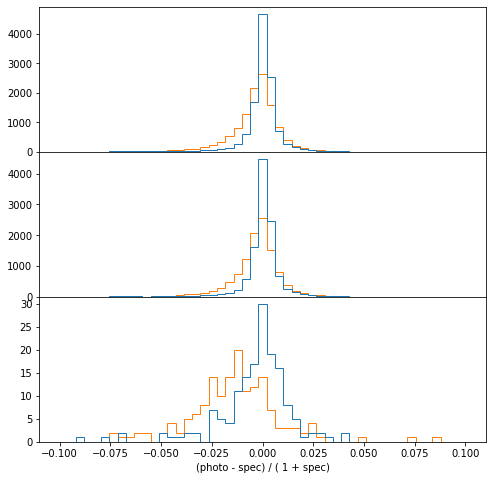

In [8]:
sel = ~np.isnan(cat['CP']['zspec_mean'])
xPau = (cat['CP']['photoz'][sel] - cat['CP']['zspec_mean'][sel]) / (1 + cat['CP']['zspec_mean'][sel])
xCosmos = (cat['CP']['PHOTOZ'][sel] - cat['CP']['zspec_mean'][sel]) / (1 + cat['CP']['zspec_mean'][sel])

bins = np.linspace(-0.1, 0.1, 50)

f, ax = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8, 8))
ax[0].hist([xPau, xCosmos], histtype='step', bins=bins)
zsel = cat['CP']['zspec_mean'][sel] < 1
ax[1].hist([xPau[zsel], xCosmos[zsel]], histtype='step', bins=bins)
zsel = cat['CP']['zspec_mean'][sel] > 1.4
ax[2].hist([xPau[zsel], xCosmos[zsel]], histtype='step', bins=bins)

ax[2].set_xlabel('(photo - spec) / ( 1 + spec)')
plt.show()
plt.close()

## DESwl subset

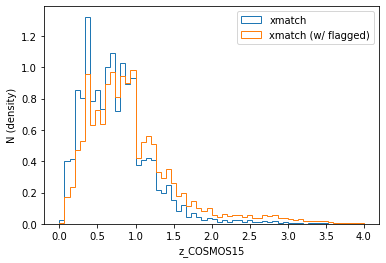

In [8]:
plt.hist(cat['C2015_DESwl']['PHOTOZ'], bins=60, range=(0, 4), align='mid',
         histtype='step', density=True, label='xmatch');
plt.hist(cat['C2015_DESwl_noflag']['PHOTOZ'], bins=60, range=(0, 4), align='mid',
         histtype='step', density=True, label='xmatch (w/ flagged)');
# plt.hist(cat['C2015_DESwl_mag']['PHOTOZ'], bins=60, range=(0, 4), align='mid',
#          histtype='step', density=True, label='i<22.5');
plt.xlabel('z_COSMOS15')
plt.ylabel('N (density)')
plt.legend()
plt.show()
plt.close()

In [9]:
# # https://stackoverflow.com/questions/64767788/compute-mean-value-per-pixel-using-weighted-2d-histogram

# counts, xbins, ybins = np.histogram2d(zP, zC, range=[(0, 5), (0, 5)], bins=(50, 50))
# sums, _, _ = np.histogram2d(zP, zC, weights=zPC_diff, range=[(0, 5), (0, 5)], bins=(xbins, ybins))

# with np.errstate(divide='ignore', invalid='ignore'):  # suppress possible divide-by-zero warnings
#     m3 = plt.pcolormesh(ybins, xbins, sums / counts, vmin=-4, vmax=4, cmap='coolwarm')
# cbar = plt.colorbar(m3)

# plt.ylabel('z_PAU')
# plt.xlabel('z_COSMOS')
# cbar.set_label('<z_PAU - z_COSMOS>_in pixel')

# plt.plot((0, 5), (0, 5), '--k')

# plt.tight_layout()
# plt.show()
# plt.close()


# # plt.scatter(zC, zP, c=zPC_diff, cmap='coolwarm')
# # plt.plot((0, 5), (0, 5), '--k')
# # cbar = plt.colorbar()
# # cbar.set_label('<z_PAU - z_COSMOS>')
# # plt.ylabel('z_PAU')
# # plt.xlabel('z_COSMOS')
# # plt.show()
# # plt.close()

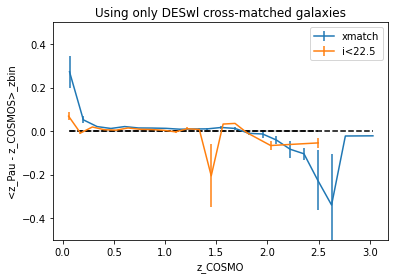

In [10]:
plot_zdiff(zdiff['CP15_DESwl']['zC15'], zdiff['CP15_DESwl']['zdiff'], label='xmatch')
plot_zdiff(zdiff['CP15_DESwl_mag']['zC15'], zdiff['CP15_DESwl_mag']['zdiff'], label='i<22.5')

plt.xlabel('z_COSMO')
plt.ylabel('<z_Pau - z_COSMOS>_zbin')
plt.ylim((-0.5, 0.5))
plt.title('Using only DESwl cross-matched galaxies')
plt.legend()
plt.show()
plt.close()

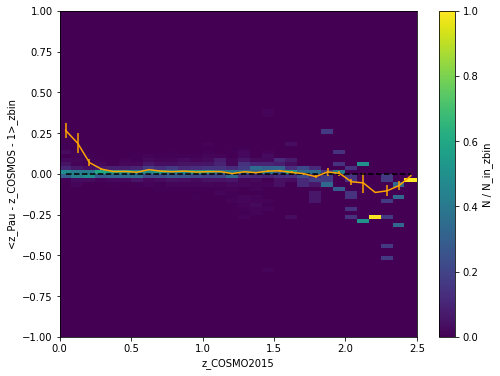

In [11]:
plt.figure(figsize=(8, 6))
h, z_edges, zdiff_edges = np.histogram2d(zdiff['CP15_DESwl']['zC15'], zdiff['CP15_DESwl']['zdiff'],
                                         range=((0, 2.5), (-1, 1)),
                                         bins=(30, 80))
hTn = h.T / np.sum(h.T, axis=0)

# hTn[np.where(hTn == 0)] = np.nan
plt.pcolormesh(z_edges, zdiff_edges, hTn) #, cmap='Greys')
c = plt.colorbar()
plot_zdiff(zdiff['CP15_DESwl']['zC15'], zdiff['CP15_DESwl']['zdiff'], z_edges=z_edges, color='orange')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_Pau - z_COSMOS - 1>_zbin')
c.set_label('N / N_in_zbin')
# plt.ylim((-1.5, 1.5))
# plt.legend()
plt.show()
plt.close()

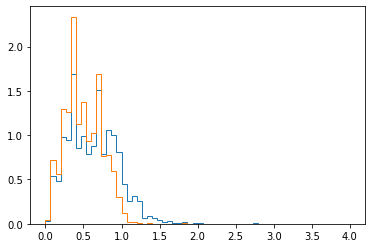

In [12]:
plt.hist(zdiff['CP15_DESwl']['zP'], bins=60, range=(0, 4), align='mid', histtype='step', density=True);
plt.hist(zdiff['CP15_DESwl_mag']['zP'], bins=60, range=(0, 4), align='mid', histtype='step', density=True);

## HSC subset

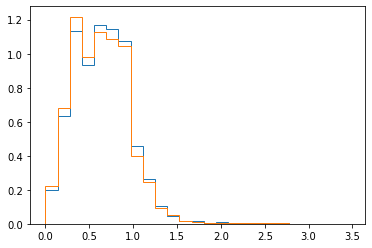

In [15]:
plt.hist(zdiff['CP15_HSC']['zC15'], bins=25, histtype='step', range=(0, zdiff['CP15_HSC']['zC15'].max()), density=True);
plt.hist(zdiff['CP15_HSC_mag']['zC15'], bins=25, histtype='step', range=(0, zdiff['CP15_HSC']['zC15'].max()), density=True);
# plt.hist(CP15_DESwl['zC15'], bins=25, histtype='step', range=(0, CP15_HSC['zC15'].max()), density=True);

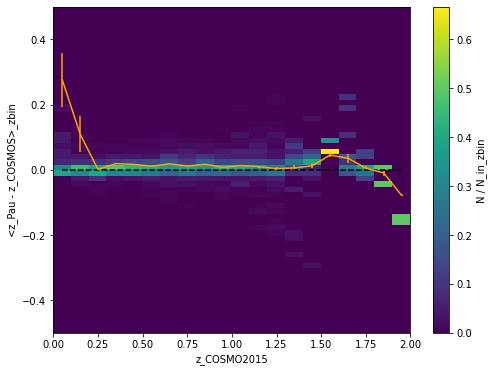

In [36]:
plt.figure(figsize=(8, 6))
h, z_edges, zdiff_edges = np.histogram2d(zdiff['CP15_HSC']['zC15'], zdiff['CP15_HSC']['zdiff'], bins=(20, 60),
                                         range=((0, 2), (-0.5, 0.5)))
hTn = h.T / np.sum(h.T, axis=0)

# hTn[np.where(hTn == 0)] = np.nan
plt.pcolormesh(z_edges, zdiff_edges, hTn) #, cmap='Greys')
c = plt.colorbar()
plot_zdiff(zdiff['CP15_HSC']['zC15'], zdiff['CP15_HSC']['zdiff'], z_edges=z_edges, color='orange')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_Pau - z_COSMOS>_zbin')
c.set_label('N / N_in_zbin')
# plt.ylim((-1.5, 1.5))
# plt.legend()
plt.show()
plt.close()

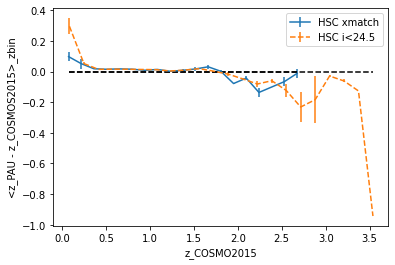

In [37]:
plot_zdiff(zdiff['CP15_HSC']['zC15'], zdiff['CP15_HSC']['zdiff'], label='HSC xmatch')
plot_zdiff(zdiff['CP15_HSC_mag']['zC15'], zdiff['CP15_HSC_mag']['zdiff'], label='HSC i<24.5', ls='--')
# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.legend()
# plt.title('Using only DESwl cross-matched galaxies')
plt.show()
plt.close()

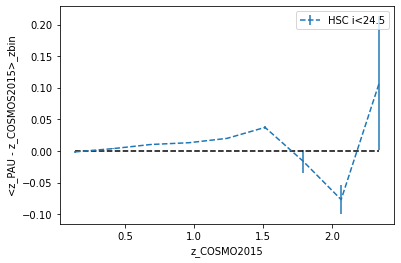

In [74]:
# plot_zdiff(zdiff['CP15_HSC']['zC15'], zdiff['CP15_HSC']['zdiff'], label='HSC xmatch')
sel = zdiff['CP15_HSC_mag']['zP'] < 2.5
plot_zdiff(zdiff['CP15_HSC_mag']['zP'][sel], zdiff['CP15_HSC_mag']['zdiff'][sel],
           label='HSC i<24.5', ls='--', bins=10)

plt.plot()

plt.xlabel('z_COSMO2015')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.legend()
# plt.title('Using only DESwl cross-matched galaxies')
plt.show()
plt.close()

## Fit

In [21]:
z_edges = [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0]

[-0.00254264  0.01767628]
chi2 = 0.6959508627738725 dof = 4 p-value = 0.04817267794317226


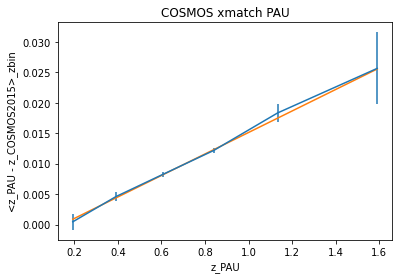

In [23]:
# CP15
x, y, err = bin_zdiff(zdiff['CP15']['zP'], zdiff['CP15']['zdiff'], 
                      z_edges=z_edges,
                      rdev=False)
# sel = x < 1.7
popt, pcov = curve_fit(LinFit, x[sel], y[sel], sigma=err[sel], p0=(-0.01, 0.01))

yfit = LinFit(x, *popt)
zdiff['CP15']['popt'] = popt
print(popt)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
# plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_PAU')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.title('COSMOS xmatch PAU')
plt.show()
plt.close()

[-0.00104047  0.01564015]
chi2 = 10.876464169869246 dof = 4 p-value = 0.9720119628145738


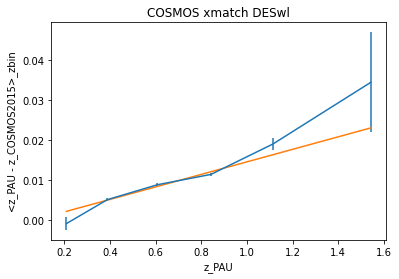

In [25]:
# DESwl
x, y, err = bin_zdiff(zdiff['CP15_DESwl']['zP'], zdiff['CP15_DESwl']['zdiff'],
                      z_edges=z_edges,
                      rdev=False)

popt, pcov = curve_fit(LinFit, x[sel], y[sel], sigma=err[sel], p0=(-0.01, 0.01))

yfit = LinFit(x, *popt)
zdiff['CP15_DESwl']['popt'] = popt
print(popt)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.xlabel('z_PAU')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.title('COSMOS xmatch DESwl')
plt.show()
plt.close()

[-0.00411756  0.01921606]
chi2 = 7.286931084367781 dof = 4 p-value = 0.8785198702385059


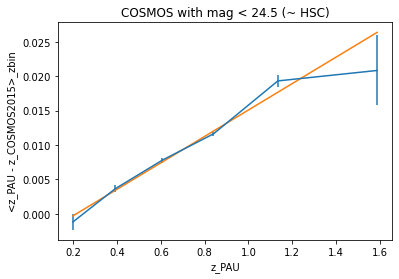

In [26]:
# HSC
x, y, err = bin_zdiff(zdiff['CP15_HSC_mag']['zP'], zdiff['CP15_HSC_mag']['zdiff'],
                      z_edges=z_edges,
                      rdev=False)

popt, pcov = curve_fit(LinFit, x[sel], y[sel], sigma=err[sel])
yfit = LinFit(x, *popt)
zdiff['CP15_HSC_mag']['popt'] = popt
print(popt)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.xlabel('z_PAU')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 24.5 (~ HSC)')
plt.show()
plt.close()

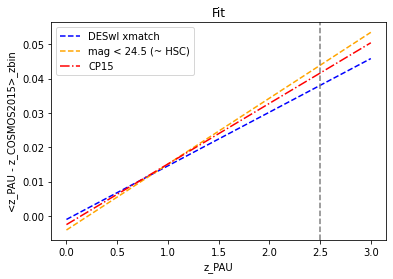

In [27]:
X = np.linspace(0, 3, 1000)

# DESwl 
plt.plot(X, LinFit(X, *zdiff['CP15_DESwl']['popt']), '--', label='DESwl xmatch', color='b')

# HSC
plt.plot(X, LinFit(X, *zdiff['CP15_HSC_mag']['popt']), '--', label='mag < 24.5 (~ HSC)', color='orange')

# CP15
plt.plot(X, LinFit(X, *zdiff['CP15']['popt']), '-.', label='CP15', color='r')

plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_PAU')
plt.ylabel('<z_PAU - z_COSMOS2015>_zbin')
plt.title('Fit')
plt.legend()
plt.show()
plt.close()

In [41]:
def get_nz(t, dz_popt):
    z = t.z
    nz = interp1d(z, t.nz)
    
    #dz = ztrue - zfalse
    A, B = dz_popt
    dz = A + B * z
    jacob = (1 - B)
    z_out = z - dz
    # dn/dzt = dzf/dzt|_zt * dn/dzf|_zt
    nz_out = jacob * nz(z_out)
    return nz_out

# Generate cosmology
cosmo = ccl.CosmologyVanillaLCDM()

# Create CCL Tracers
ccl_tracers = {}
for n, t in s.tracers.items():
    if n.split('__')[0] == 'DESwl':
        ks = 'CP15_DESwl'
    elif n.split('__')[0] == 'HSC':
        ks = 'CP15_HSC_mag'
    else:
        raise ValueError(f'WTF is {n}?')
        
    ccl_tracers[n] = {'orig': ccl.WeakLensingTracer(cosmo, (t.z, t.nz)),
                      'bias_fit_CP': ccl.WeakLensingTracer(cosmo,
                                                              (t.z, get_nz(t, zdiff['CP15']['popt']))),
                      'bias_fit_survey': ccl.WeakLensingTracer(cosmo,
                                                              (t.z, get_nz(t, zdiff[ks]['popt']))),
                     }
    
th = {}
th['DESwl'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'DESwl'),
               'bias_fit_CP': get_theory(cosmo, ccl_tracers, 'bias_fit_CP', 'DESwl'),
               'bias_fit_survey': get_theory(cosmo, ccl_tracers, 'bias_fit_survey', 'DESwl')}

th['HSC'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'HSC'),
             'bias_fit_CP': get_theory(cosmo, ccl_tracers, 'bias_fit_CP', 'HSC'),
             'bias_fit_survey': get_theory(cosmo, ccl_tracers, 'bias_fit_survey', 'HSC')}

th['all'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'all'),
             'bias_fit_CP': get_theory(cosmo, ccl_tracers, 'bias_fit_CP', 'all'),
             'bias_fit_survey': get_theory(cosmo, ccl_tracers, 'bias_fit_survey', 'all')}

In [53]:
def get_dchi2(survey, nz1, nz2, return_size=True):
    # Full thing
    # Case 1: No dz 
    th1 = th[survey][nz1]
    # Case 2: dz fitted to the whole PAU vs COSMOS cat
    th2 = th[survey][nz2]

    r = th1 - th2
    chi2 = r.dot(data[survey]['icov']).dot(r)
    
    if return_size:
        return chi2, r.size
    
    return chi2


# DES + HSC
survey = 'all'
output = get_dchi2(survey, 'orig', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'orig', 'bias_fit_survey')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'bias_fit_survey', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))

print()

# DES
survey = 'DESwl'
output = get_dchi2(survey, 'orig', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'orig', 'bias_fit_survey')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'bias_fit_survey', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))

print()

# HSC
survey = 'HSC'
output = get_dchi2(survey, 'orig', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'orig', 'bias_fit_survey')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))
output = get_dchi2(survey, 'bias_fit_survey', 'bias_fit_CP')
print('No dz vs dz ({} PAU vs COSMOS): chi2 = {} for ndata = {}'.format(survey, *output))

No dz vs dz (all PAU vs COSMOS): chi2 = 1.0587040837393422 for ndata = 560
No dz vs dz (all PAU vs COSMOS): chi2 = 1.0908279173109614 for ndata = 560
No dz vs dz (all PAU vs COSMOS): chi2 = 0.0055390750283732405 for ndata = 560

No dz vs dz (DESwl PAU vs COSMOS): chi2 = 0.7914837128994313 for ndata = 390
No dz vs dz (DESwl PAU vs COSMOS): chi2 = 0.8119153370363308 for ndata = 390
No dz vs dz (DESwl PAU vs COSMOS): chi2 = 0.0031168167428109895 for ndata = 390

No dz vs dz (HSC PAU vs COSMOS): chi2 = 0.2690394565863986 for ndata = 170
No dz vs dz (HSC PAU vs COSMOS): chi2 = 0.27046669628919456 for ndata = 170
No dz vs dz (HSC PAU vs COSMOS): chi2 = 0.0018278708012576517 for ndata = 170


# COSMOS2015 vs COSMOS2020 [Not used in the end. Need more bands not better noise]

In [76]:
def C2015_x_C2020(c2015, c2020):
    _, ix20, ix15 = np.intersect1d(c2020['ID_COSMOS2015'], c2015['NUMBER'], return_indices=True)
    
    # Make sure we're looking at the same object
    assert np.max(np.abs(c2015[ix15]['ALPHA_J2000'] / c2020[ix20]['ALPHA_J2000'] -1)) < 1e-5
    assert np.max(np.abs(c2015[ix15]['DELTA_J2000'] / c2020[ix20]['DELTA_J2000'] -1)) < 1e-4

    zC15 = c2015['PHOTOZ'][ix15]
#     zC20 = c2020['lp_zMinChi2'][ix20]
    zC20 = c2020['lp_zBEST'][ix20]
    zC20_B = c2020['lp_zPDF'][ix20]
    z20_15_diff = zC20 - zC15
    z20_15_diff_B = zC20_B - zC15

    print('Stars? 20: ', np.sum(c2020['lp_type'][ix20] == 1),
         'Stars? 15: ', np.sum(c2015['TYPE'][ix15] == 1)
         )

    clean = np.isnan(zC20) + (c2020['lp_type'][ix20] != 0)
    zC15 = zC15[~clean]
    zC20 = zC20[~clean]
    z20_15_diff = z20_15_diff[~clean]
    z20_15_diff_B = z20_15_diff_B[~clean]   
    
    return {'zC15': zC15, 'zC20': zC20, 'zdiff': z20_15_diff, 'zdiff_B': z20_15_diff_B}

In [77]:
# Compute zdiff for DES and hSC
zdiff['C15_20_DESwl'] = C2015_x_C2020(cat['C2015_DESwl'], cat['C2020'])
# zdiff['C15_20_DESwl_noflag'] = C2015_x_C2020(cat['C2015_DESwl_noflag'], cat['C2020'])
zdiff['C15_20_DESwl_mag'] = C2015_x_C2020(cat['C2015_DESwl_mag'], cat['C2020'])
zdiff['C15_20F_DESwl'] = C2015_x_C2020(cat['C2015_DESwl'], cat['C2020F'])

zdiff['C15_20_HSC'] = C2015_x_C2020(cat['C2015_HSC'], cat['C2020'])
zdiff['C15_20_HSC_mag'] = C2015_x_C2020(cat['C2015_HSC_mag'], cat['C2020'])
zdiff['C15_20F_HSC'] = C2015_x_C2020(cat['C2015_HSC'], cat['C2020F'])

Stars? 20:  52 Stars? 15:  0
Stars? 20:  151 Stars? 15:  0
Stars? 20:  54 Stars? 15:  0
Stars? 20:  11 Stars? 15:  0
Stars? 20:  394 Stars? 15:  0
Stars? 20:  14 Stars? 15:  0


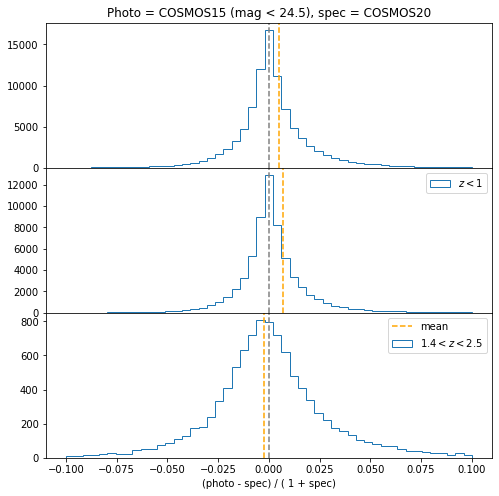

In [87]:
# sel = ~np.isnan(cat['CP']['zspec_mean'])
# xPau = (cat['CP']['photoz'][sel] - cat['CP']['zspec_mean'][sel]) / (1 + cat['CP']['zspec_mean'][sel])

spec = zdiff['C15_20_HSC_mag']['zC20']
photo = zdiff['C15_20_HSC_mag']['zC15']
xCosmos = (photo - spec) / (1 + spec)

bins = np.linspace(-0.1, 0.1, 50)

f, ax = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8, 8))
ax[0].hist([xCosmos], histtype='step', bins=bins)
ax[0].axvline(np.mean(xCosmos), c='orange', ls='--')
ax[0].axvline(0, c='gray', ls='--')

zsel = spec < 1
ax[1].hist([xCosmos[zsel]], histtype='step', bins=bins, label='$z < 1$')
ax[1].axvline(np.mean(xCosmos[zsel]), c='orange', ls='--')
ax[1].axvline(0, c='gray', ls='--')
ax[1].legend()


zsel = (spec > 1.4) * (spec < 2.5)
ax[2].hist([xCosmos[zsel]], histtype='step', bins=bins, label='$1.4 < z < 2.5$')
ax[2].axvline(np.mean(xCosmos[zsel]), c='orange', ls='--', label='mean')
ax[2].axvline(0, c='gray', ls='--')
ax[2].legend()

ax[2].set_xlabel('(photo - spec) / ( 1 + spec)')
ax[0].set_title('Photo = COSMOS15 (mag < 24.5), spec = COSMOS20')
plt.show()
plt.close()

## Plots

### DESwl

In [7]:
# zdiff['C15_20_DESwl'] = C2015_x_C2020(cat['C2015_DESwl'], cat['C2020'])
# # zdiff['C15_20_DESwl_noflag'] = C2015_x_C2020(cat['C2015_DESwl_noflag'], cat['C2020'])
# zdiff['C15_20_DESwl_mag'] = C2015_x_C2020(cat['C2015_DESwl_mag'], cat['C2020'])
# zdiff['C15_20F_DESwl'] = C2015_x_C2020(cat['C2015_DESwl'], cat['C2020F'])

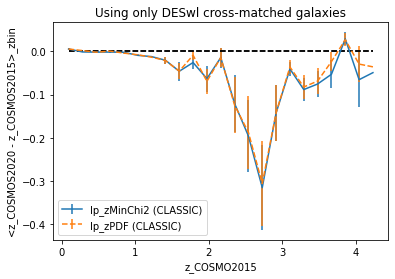

In [10]:
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], label='lp_zMinChi2 (CLASSIC)')
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff_B'], label='lp_zPDF (CLASSIC)', ls='--')
# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.legend()
plt.title('Using only DESwl cross-matched galaxies')
plt.show()
plt.close()

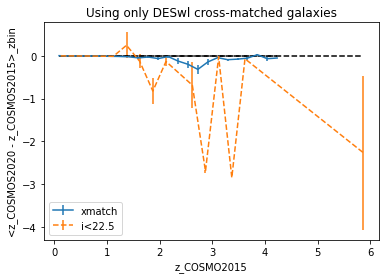

In [11]:
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], label='xmatch')
plot_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'], label='i<22.5', ls='--')
# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.legend()
plt.title('Using only DESwl cross-matched galaxies')
plt.show()
plt.close()

In [12]:
# plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], label='w/o flagged')
# plot_zdiff(zdiff['C15_20_DESwl_noflag']['zC15'], zdiff['C15_20_DESwl_noflag']['zdiff'], label='w/ flagged', ls='--')
# plt.xlabel('z_COSMO2015')
# plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
# plt.legend()
# plt.title('Using only DESwl cross-matched galaxies')
# plt.show()
# plt.close()

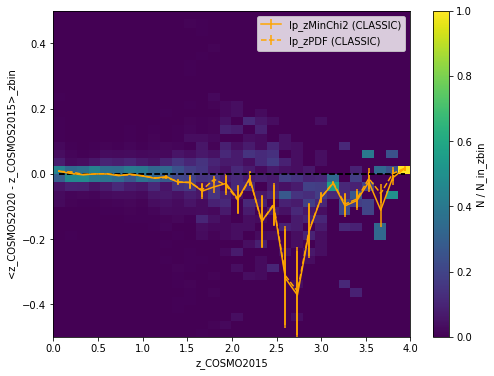

In [13]:
plt.figure(figsize=(8, 6))
h, z_edges, zdiff_edges = np.histogram2d(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'],
                                         range=((0, 4), (-1, 1)), bins=(30, 80))
hTn = h.T / np.sum(h.T, axis=0)

# hTn[np.where(hTn == 0)] = np.nan
plt.pcolormesh(z_edges, zdiff_edges, hTn) #, cmap='Greys')
c = plt.colorbar()
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], z_edges=z_edges, label='lp_zMinChi2 (CLASSIC)', color='orange')
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff_B'], z_edges=z_edges, label='lp_zPDF (CLASSIC)', ls='--', color='orange')

plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
c.set_label('N / N_in_zbin')
plt.ylim((-0.5, 0.5))
plt.legend()
plt.show()
plt.close()

### HSC

In [8]:
# zdiff['C15_20_HSC'] = C2015_x_C2020(cat['C2015_HSC'], cat['C2020'])
# zdiff['C15_20_HSC_mag'] = C2015_x_C2020(cat['C2015_HSC_mag'], cat['C2020'])
# zdiff['C15_20F_HSC'] = C2015_x_C2020(cat['C2015_HSC'], cat['C2020F'])

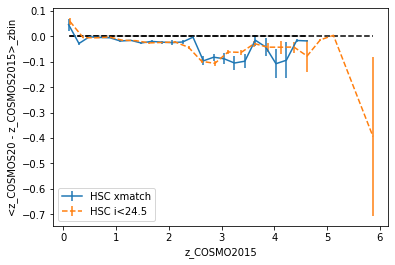

In [47]:
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], label='HSC xmatch')
plot_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], label='HSC i<24.5', ls='--')
# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS20 - z_COSMOS2015>_zbin')
plt.legend()
# plt.title('Using only DESwl cross-matched galaxies')
plt.show()
plt.close()

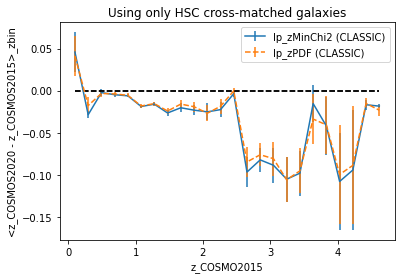

In [48]:
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], label='lp_zMinChi2 (CLASSIC)')
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff_B'], label='lp_zPDF (CLASSIC)', ls='--')

# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')

plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.legend()
plt.title('Using only HSC cross-matched galaxies')
plt.show()
plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


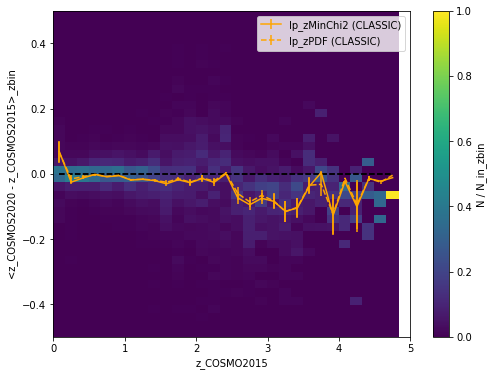

In [49]:
plt.figure(figsize=(8, 6))
h, z_edges, zdiff_edges = np.histogram2d(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], range=((0, 5), (-1, 1)), bins=(30, 80))
hTn = h.T / np.sum(h.T, axis=0)

# hTn[np.where(hTn == 0)] = np.nan
plt.pcolormesh(z_edges, zdiff_edges, hTn) #, cmap='Greys')
c = plt.colorbar()
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], z_edges=z_edges, label='lp_zMinChi2 (CLASSIC)', color='orange')
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff_B'], z_edges=z_edges, label='lp_zPDF (CLASSIC)', ls='--', color='orange')

plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
c.set_label('N / N_in_zbin')
plt.ylim((-0.5, 0.5))
plt.legend()
plt.show()
plt.close()

### DESwl and HSC

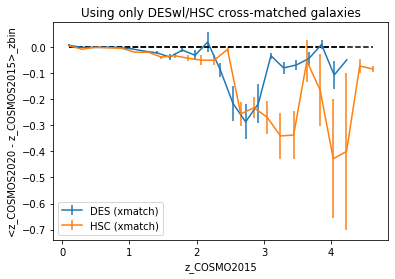

In [97]:
plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], label='DES (xmatch)')
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], label='HSC (xmatch)')

plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.legend()
plt.title('Using only DESwl/HSC cross-matched galaxies')
plt.show()
plt.close()

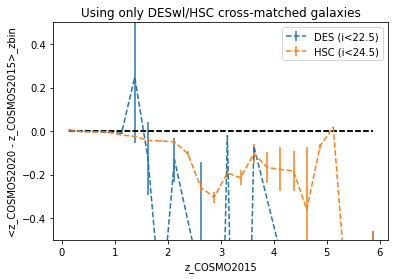

In [98]:
plot_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'], label='DES (i<22.5)', ls='--')
plot_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], label='HSC (i<24.5)', ls='--')

# plot_zdiff(zC15F, z20F_15_diff, label='lp_zMinChi2 (FARMER)')
# plot_zdiff(zC15F, z20F_15_diff_B, label='lp_zPDF (FARMER)', ls='--')
plt.ylim([-0.5, 0.5])
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.legend()
plt.title('Using only DESwl/HSC cross-matched galaxies')
plt.show()
plt.close()

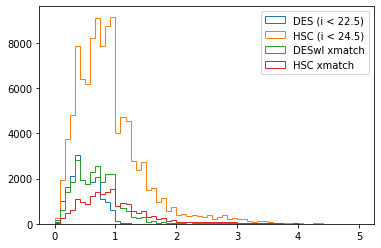

In [9]:
nDESwl, b, _ = plt.hist(zdiff['C15_20_DESwl_mag']['zC15'], histtype='step',
                        range=(0, 5), bins=60, label='DES (i < 22.5)')
nHSC, b, _ = plt.hist(zdiff['C15_20_HSC_mag']['zC15'], histtype='step',
                      range=(0, 5), bins=60, label='HSC (i < 24.5)')

nHSC, b, _ = plt.hist(zdiff['C15_20_DESwl']['zC15'], histtype='step',
                      range=(0, 5), bins=60, label='DESwl xmatch')
nHSC, b, _ = plt.hist(zdiff['C15_20_HSC']['zC15'], histtype='step',
                      range=(0, 5), bins=60, label='HSC xmatch')
plt.legend()
plt.show()
plt.close()

## Systematic parametrization

### Absolute difference

[-0.00799124  2.77228993]
[[2.13298175e-06 1.47468120e-04]
 [1.47468120e-04 1.41873930e-01]]
chi2 = 16.99520109195813 dof = 7 p-value = 0.9825728469271746


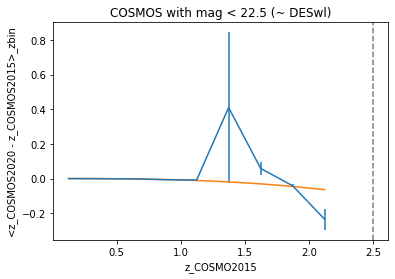

In [74]:
# DESwl
# z_edges = np.concatenate([np.linspace(0, 1, 10),
#                            np.linspace(1, zdiff['C15_20_DESwl_mag']['zC15'].max(), 10)])
x, y, err = bin_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'],
                      rdev=False) #, z_edges=z_edges)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])

yfit = fit1(x, *popt)
zdiff['C15_20_DESwl_mag']['fit_x'] = x
zdiff['C15_20_DESwl_mag']['fit_y'] = y
zdiff['C15_20_DESwl_mag']['popt'] = popt
print(popt)
print(pcov)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 22.5 (~ DESwl)')
plt.show()
plt.close()

[-3.12455236e-03  3.22625033e+00]
[[8.37614557e-07 4.87173297e-04]
 [4.87173297e-04 6.65699194e-01]]
chi2 = 23.412434577019916 dof = 11 p-value = 0.9845489450186135


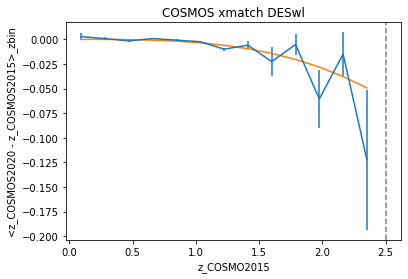

In [75]:
# DESwl
# z_edges = np.concatenate([np.linspace(0, 1, 20),
#                           np.linspace(1, zdiff['C15_20_DESwl']['zC15'].max(), 10)])
x, y, err = bin_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'],
                      rdev=False) #, z_edges=z_edges)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])

yfit = fit1(x, *popt)
zdiff['C15_20_DESwl']['fit_x'] = x
zdiff['C15_20_DESwl']['fit_y'] = y
zdiff['C15_20_DESwl']['popt'] = popt
print(popt)
print(pcov)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS xmatch DESwl')
plt.show()
plt.close()

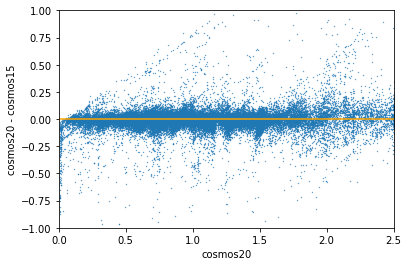

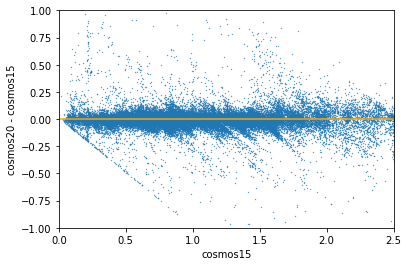

In [13]:
plt.scatter(zdiff['C15_20_HSC_mag']['zC20'], zdiff['C15_20_HSC_mag']['zdiff'], s=0.1)
plt.axhline(0, c='orange')
plt.xlim([0, 2.5])
plt.ylim([-1, 1])
plt.ylabel('cosmos20 - cosmos15')
plt.xlabel('cosmos20')
plt.show()
plt.close()

plt.scatter(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], s=0.1)
plt.axhline(0, c='orange')
plt.xlim([0, 2.5])
plt.ylim([-1, 1])
plt.ylabel('cosmos20 - cosmos15')
plt.xlabel('cosmos15')
plt.show()
plt.close()

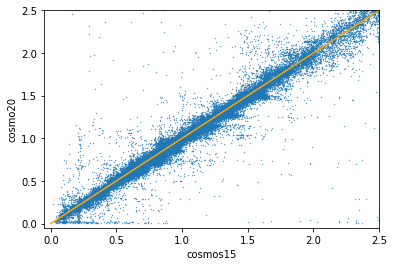

In [9]:
plt.scatter(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zC20'], s=0.1)
plt.plot([0, 4], [0, 4], c='orange')
plt.ylabel('cosmo20')
plt.xlabel('cosmos15')
plt.xlim([-0.05, 2.5])
plt.ylim([-0.05, 2.5])
plt.show()
plt.close()

[-1.32229161e-03  3.91399066e+00]
[[1.21478560e-06 1.35970120e-03]
 [1.35970120e-03 1.89440832e+00]]
chi2 = 98.50488726524276 dof = 8 p-value = 1.0


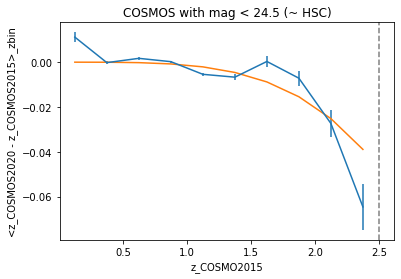

In [80]:
# HSC
# z_edges = np.concatenate([np.linspace(0, 2.5, 10)]),
#                           np.linspace(2, zdiff['C15_20_HSC_mag']['zC15'].max(), 10)])
# selection = zdiff['C15_20_HSC_mag']['zC20'] > 0.3
x, y, err = bin_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'],
                      rdev=False) #, z_edges=z_edges)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])
yfit = fit1(x, *popt)
zdiff['C15_20_HSC_mag']['fit_x'] = x
zdiff['C15_20_HSC_mag']['fit_y'] = y
zdiff['C15_20_HSC_mag']['popt'] = popt
print(popt)
print(pcov)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 24.5 (~ HSC)')
plt.show()
plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power
/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in power


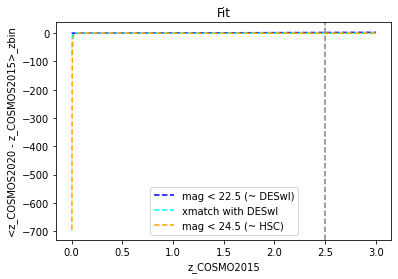

In [67]:
X = np.linspace(0, 3, 1000)

# DESwl 
plt.plot(X, fit1(X, *zdiff['C15_20_DESwl_mag']['popt']), '--', label='mag < 22.5 (~ DESwl)', color='b')
# x, y, err = bin_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'], rdev=False)
# sel = x < 2.5
# plt.errorbar(x[sel], y[sel], yerr=err[sel], color='b')

plt.plot(X, fit1(X, *zdiff['C15_20_DESwl']['popt']), '--', label='xmatch with DESwl', color='cyan')


# HSC
plt.plot(X, fit1(X, *zdiff['C15_20_HSC_mag']['popt']), '--', label='mag < 24.5 (~ HSC)', color='orange')
# x, y, err = bin_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], rdev=False)
# sel = x < 2.5
# plt.errorbar(x[sel], y[sel], yerr=err[sel], color='orange')

# plt.plot(X, fit1(X, *zdiff['C15_20_HSC']['popt']), '--', label='xmatch with HSC', color='gold')


plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('Fit')
plt.legend()
plt.show()
plt.close()

### Prior estimation

In [15]:
def estimate_cov_bootsrap(z, zdiff, pct=1, return_params=True):
    ix = np.arange(z.size)
    np.random.shuffle(ix)
    z = z[ix]
    zdiff = zdiff[ix]
    
    step = int(z.size * pct / 100.)
    its = z.size / step
    its = int(its)
        
    if (its - 1) * step < z.size:
        its += 1
        
    params = np.zeros((its, 2))
    for i in range(its):
        sel_ix = np.delete(ix, np.arange(i * step, np.min(((i+1) * step, z.size))))
        x, y, err = bin_zdiff(z[sel_ix], zdiff[sel_ix], rdev=False)
        sel = x < 2.5
        popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])
        params[i] = popt
        
    cov = np.cov(params.T) * (its - 1)
    if return_params:
        return cov, params
    return cov

In [16]:
def estimate_cov_MCMC(z, zdiff, zmax=2.5, ndots=1000, Alim=None, alphalim=None):
    x, y, err = bin_zdiff(z, zdiff,rdev=False) #, z_edges=z_edges)
    sel = x < zmax
    popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])
    
    n = 5
    if Alim is None:
        A = np.linspace(popt[0] - 100 * n * pcov[0, 0], popt[0] + 100 * n * pcov[0, 0], ndots)
    else:
        A = np.linspace(*Alim, ndots)
    
    if alphalim is None:
        alpha = np.linspace(popt[1] - n * pcov[1, 1], popt[1] + n * pcov[1, 1], ndots)
    else:
        alpha = np.linspace(*alphalim, ndots)
        
    chi2 = np.zeros((A.size, alpha.size))
    for i, Ai in enumerate(A):
        for j, aj in enumerate(alpha):
            yfit = fit1(x[sel], Ai, aj)
            chi2[i, j] = np.sum((y[sel] - yfit)**2 / err[sel] ** 2)
            
    P = np.exp(- 0.5 * chi2)
    norm = simps(simps(P, A, axis=0), alpha)
    P /= norm
    
    mA = simps(simps(A * P, A, axis=0), alpha)
    mA2 = simps(simps(A ** 2 * P, A, axis=0), alpha)
    
    ma = simps(simps(alpha * P, A, axis=0), alpha)
    ma2 = simps(simps(alpha ** 2 * P, A, axis=0), alpha)
    
    maA = simps(simps(alpha * A * P, A, axis=0), alpha)
    
    popt = (mA, ma)
    pcov = (((mA2 - mA**2), (maA - ma * mA)),
           ((maA - ma * mA), (ma2 - ma ** 2)))
    
    return A, alpha, chi2, popt, np.array(pcov)

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


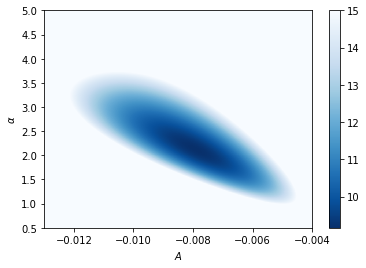

BF params: [-0.0079374  2.1404179]
chi2 = 9.164106608113855 dof = 7 p-value = 0.7589123193576799

Cov fit: [[ 2.25160196e-06 -5.77445119e-04]
 [-5.77445119e-04  2.50181068e-01]]

Cov bootstrap: [[ 5.82622027e-06 -1.98001873e-03]
 [-1.98001873e-03  8.41777303e-01]]

Cov MCMC: [[ 1.30937472e-06 -6.54687359e-04]
 [-6.54687359e-04  3.27343680e-01]]

Mean params MCMC: (-0.007697811521657523, 2.3489057608287616)


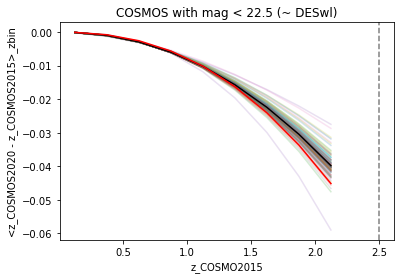

In [17]:
# DESwl
# z_edges = np.concatenate([np.linspace(0, 1, 20),
#                           np.linspace(1, zdiff['C15_20_DESwl_mag']['zC15'].max(), 10)])
x, y, err = bin_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'],
                      rdev=False) #, z_edges=z_edges)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel], absolute_sigma=True)

yfit = fit1(x, *popt)
cov, popts = estimate_cov_bootsrap(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'])
A, alpha, chi2_grid, popt_mcmc, cov_mcmc = estimate_cov_MCMC(zdiff['C15_20_DESwl_mag']['zC15'],
                                               zdiff['C15_20_DESwl_mag']['zdiff'],
                                              ndots=1000, Alim=(-0.004, -0.013), alphalim=(0.5, 5))

plt.pcolormesh(A, alpha, chi2_grid.T, cmap='Blues_r', vmax=15)
plt.colorbar()
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$A$')
plt.show()

zdiff['C15_20_DESwl_mag']['fit_x'] = x
zdiff['C15_20_DESwl_mag']['fit_y'] = y
zdiff['C15_20_DESwl_mag']['popt'] = popt
zdiff['C15_20_DESwl_mag']['cov_cfit'] = pcov
zdiff['C15_20_DESwl_mag']['cov_bootstrap'] = cov
zdiff['C15_20_DESwl_mag']['popt_mcmc'] = popt_mcmc
zdiff['C15_20_DESwl_mag']['cov_mcmc'] = cov_mcmc


print('BF params:', popt)
chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)
print()
print('Cov fit:', pcov)
print()
print('Cov bootstrap:', cov)
print()
print('Cov MCMC:', cov_mcmc)
print()
print('Mean params MCMC:', popt_mcmc)



for p in popts:
    plt.plot(x[sel], fit1(x, *p)[sel], alpha=0.2)

# plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel], c='k')
plt.plot(x[sel], fit1(x[sel], *popt_mcmc), c='red')
plt.axvline(2.5, ls='--', c='gray')


plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 22.5 (~ DESwl)')
plt.show()
plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


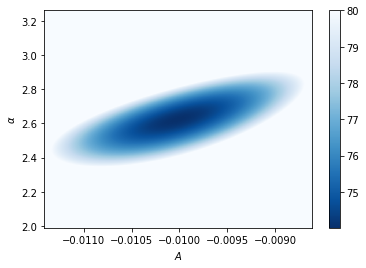

BF params: [-0.01001383  2.62571162]
chi2 = 74.01066741669686 dof = 8 p-value = 0.9999999999992218

Cov fit: [[3.02315639e-07 4.53212518e-05]
 [4.53212518e-05 1.37771899e-02]]

Cov bootstrap: [[2.98410199e-07 3.98317414e-05]
 [3.98317414e-05 1.19256551e-02]]

Cov MCMC: [[6.04788225e-08 2.75615323e-05]
 [2.75615323e-05 1.25603977e-02]]

Mean params MCMC: (-0.010021104228078411, 2.6223949456267186)


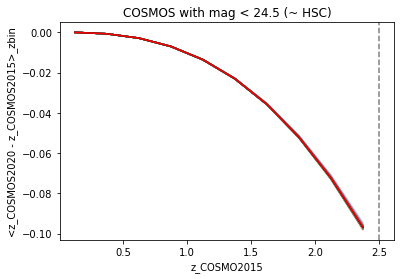

In [18]:
# HSC
# z_edges = np.concatenate([np.linspace(0, 1, 20),
#                           np.linspace(1, zdiff['C15_20_HSC_mag']['zC15'].max(), 10)])
x, y, err = bin_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'],
                      rdev=False) #, z_edges=z_edges)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel], absolute_sigma=True)

yfit = fit1(x, *popt)
cov, popts = estimate_cov_bootsrap(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'])
A, alpha, chi2_grid, popt_mcmc, cov_mcmc = estimate_cov_MCMC(zdiff['C15_20_HSC_mag']['zC15'],
                                               zdiff['C15_20_HSC_mag']['zdiff'],
                                              ndots=1000)

plt.pcolormesh(A, alpha, chi2_grid.T, cmap='Blues_r', vmax=80)
plt.colorbar()
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$A$')
plt.show()

zdiff['C15_20_HSC_mag']['fit_x'] = x
zdiff['C15_20_HSC_mag']['fit_y'] = y
zdiff['C15_20_HSC_mag']['popt'] = popt
zdiff['C15_20_HSC_mag']['cov_cfit'] = pcov
zdiff['C15_20_HSC_mag']['cov_bootstrap'] = cov
zdiff['C15_20_HSC_mag']['popt_mcmc'] = popt_mcmc
zdiff['C15_20_HSC_mag']['cov_mcmc'] = cov_mcmc


print('BF params:', popt)
chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)
print()
print('Cov fit:', pcov)
print()
print('Cov bootstrap:', cov)
print()
print('Cov MCMC:', cov_mcmc)
print()
print('Mean params MCMC:', popt_mcmc)



for p in popts:
    plt.plot(x[sel], fit1(x, *p)[sel], alpha=0.2)

# plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel], c='k')
plt.plot(x[sel], fit1(x[sel], *popt_mcmc), c='red')
plt.axvline(2.5, ls='--', c='gray')


plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 24.5 (~ HSC)')
plt.show()
plt.close()

### Check parametrization

We evaluate the goodness of our parametrization by computing the $C_\ell$ with the raw and fitted z_diff.

In [20]:
# Generate cosmology
cosmo = ccl.CosmologyVanillaLCDM()

fit_DESwl = lambda x: fit1(x, *zdiff['C15_20_DESwl']['popt'])
fit_DESwl_mag = lambda x: fit1(x, *zdiff['C15_20_DESwl_mag']['popt'])
fit_HSC = lambda x: fit1(x, *zdiff['C15_20_HSC_mag']['popt'])

raw_DESwl = interp1d(zdiff['C15_20_DESwl']['fit_x'], zdiff['C15_20_DESwl']['fit_y'], 
                     fill_value='extrapolate')
raw_DESwl_mag = interp1d(zdiff['C15_20_DESwl_mag']['fit_x'], zdiff['C15_20_DESwl_mag']['fit_y'], 
                     fill_value='extrapolate')
raw_HSC = interp1d(zdiff['C15_20_HSC_mag']['fit_x'], zdiff['C15_20_HSC_mag']['fit_y'],
                     fill_value='extrapolate')


def sort_pair(z, nz):
    i = np.argsort(z)
    return z[i], nz[i]

# Create CCL Tracers
ccl_tracers = {}
for n, t in s.tracers.items():
    ccl_tracers[n] = {'orig': ccl.WeakLensingTracer(cosmo, (t.z, t.nz)),
                      'bias_raw_DESwl': ccl.WeakLensingTracer(cosmo, sort_pair(t.z + raw_DESwl(t.z), t.nz)),
                      'bias_raw_DESwl_mag': ccl.WeakLensingTracer(cosmo, sort_pair(t.z + raw_DESwl_mag(t.z), t.nz)),
                      'bias_raw_HSC': ccl.WeakLensingTracer(cosmo, sort_pair(t.z + raw_HSC(t.z), t.nz)),
                      'bias_fit_DESwl': ccl.WeakLensingTracer(cosmo, (t.z + fit_DESwl(t.z), t.nz)),
                      'bias_fit_DESwl_mag': ccl.WeakLensingTracer(cosmo, (t.z + fit_DESwl_mag(t.z), t.nz)),
                      'bias_fit_HSC': ccl.WeakLensingTracer(cosmo, (t.z + fit_HSC(t.z), t.nz)),
                     }


In [25]:
th = {}
th['DESwl'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'DESwl'),
               'raw': get_theory(cosmo, ccl_tracers, 'bias_raw_DESwl', 'DESwl'),
               'fit': get_theory(cosmo, ccl_tracers, 'bias_fit_DESwl', 'DESwl'),
               'fit_HSC': get_theory(cosmo, ccl_tracers, 'bias_fit_HSC', 'DESwl'),}

th['DESwl_mag'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'DESwl'),
               'raw': get_theory(cosmo, ccl_tracers, 'bias_raw_DESwl_mag', 'DESwl'),
               'fit': get_theory(cosmo, ccl_tracers, 'bias_fit_DESwl_mag', 'DESwl'),
               'fit_HSC': get_theory(cosmo, ccl_tracers, 'bias_fit_HSC', 'DESwl'),}

th['HSC'] = {'orig': get_theory(cosmo, ccl_tracers, 'orig', 'HSC'),
             'raw': get_theory(cosmo, ccl_tracers, 'bias_raw_HSC', 'HSC'),
             'fit': get_theory(cosmo, ccl_tracers, 'bias_fit_HSC', 'HSC')}

for survey in ['DESwl', 'DESwl_mag', 'HSC']:
    r = th[survey]['raw'] - th[survey]['fit']
    chi2 = r.dot(data[survey.split('_')[0]]['icov']).dot(r)
    print(f'{survey} only Raw vs Fit:', chi2, f'     For {r.size} data points.')

DESwl only Raw vs Fit: 0.056791243017006714      For 390 data points.
DESwl_mag only Raw vs Fit: 7.649093041548305      For 390 data points.
HSC only Raw vs Fit: 0.49096881773314355      For 170 data points.


In [22]:
# Full thing
# Case 1: DES with DES fit and HSC with HSC fit
th1 = np.concatenate([th['DESwl_mag']['fit'], th['HSC']['fit']])
# Case 2: DES and HSC with HSC fit
th2 = np.concatenate([th['DESwl_mag']['fit_HSC'], th['HSC']['fit']])

r = th1 - th2
chi2 = r.dot(data['orig']['icov']).dot(r)
print('DESwl + HSC dataset:', chi2)

DESwl + HSC dataset: 0.052109181548122205


In [23]:
# Full thing
# Case 1: DES with DES fit and HSC with HSC fit
th1 = np.concatenate([th['DESwl']['fit'], th['HSC']['fit']])
# Case 2: DES and HSC with HSC fit
th2 = np.concatenate([th['DESwl']['fit_HSC'], th['HSC']['fit']])

r = th1 - th2
chi2 = r.dot(data['orig']['icov']).dot(r)
print('DESwl + HSC dataset:', chi2)

DESwl + HSC dataset: 0.058061680453161346


In [24]:
# Full thing
# Case 1: DES with DES fit and HSC with HSC fit
th1 = np.concatenate([th['DESwl']['fit'], th['HSC']['fit']])
# Case 2: DES and HSC with HSC fit
th2 = np.concatenate([th['DESwl']['fit_HSC'], th['HSC']['fit']])

r = th1 - th2
chi2 = r.dot(data['orig']['icov']).dot(r)
print('DESwl + HSC dataset:', chi2)

DESwl + HSC dataset: 0.058061680453161346


In [26]:
# Full thing
# Case 1: No dz
th1 = np.concatenate([th['DESwl']['orig'], th['HSC']['orig']])
# Case 2: DES and HSC with HSC fit
th2 = np.concatenate([th['DESwl']['fit_HSC'], th['HSC']['fit']])

r = th1 - th2
chi2 = r.dot(data['orig']['icov']).dot(r)
print('DESwl + HSC dataset:', chi2)

DESwl + HSC dataset: 0.869836893976002


### Relative difference [Not used]

[-0.00874814  1.42099732]
chi2 = 12.038731486845037 dof = 7 p-value = 0.900707664720655


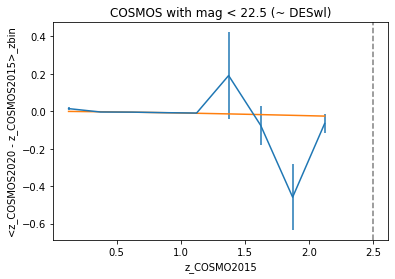

In [154]:
# DESwl
x, y, err = bin_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'], rdev=True)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])

yfit = fit1(x, *popt)
zdiff['C15_20_DESwl_mag']['popt'] = popt
print(popt)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 22.5 (~ DESwl)')
plt.show()
plt.close()

[-0.00988206  1.65966547]
chi2 = 82.92549601177579 dof = 8 p-value = 0.9999999999999875


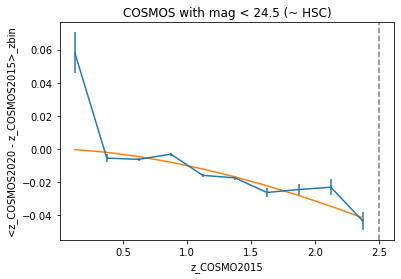

In [153]:
# HSC
x, y, err = bin_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], rdev=True)
sel = x < 2.5
popt, pcov = curve_fit(fit1, x[sel], y[sel], sigma=err[sel])
yfit = fit1(x, *popt)
zdiff['C15_20_HSC_mag']['popt'] = popt
print(popt)

chi2 = np.sum((yfit[sel] - y[sel]) ** 2 / err[sel] ** 2)
dof = sel.sum() - 2
pvalue = stats.chi2.cdf(chi2, dof)
print('chi2 =', chi2, 'dof =', dof, 'p-value =', pvalue)

plt.errorbar(x[sel], y[sel], yerr=err[sel])
plt.plot(x[sel], yfit[sel])
plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('COSMOS with mag < 24.5 (~ HSC)')
plt.show()
plt.close()

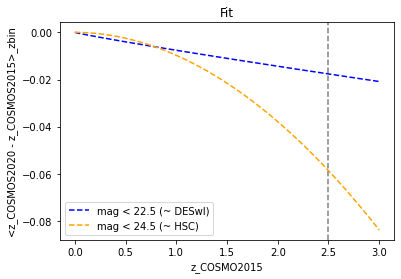

In [151]:
X = np.linspace(0, 3, 1000)

# DESwl 
plt.plot(X, fit1(X, *zdiff['C15_20_DESwl_mag']['popt']), '--', label='mag < 22.5 (~ DESwl)', color='b')
# x, y, err = bin_zdiff(zdiff['C15_20_DESwl_mag']['zC15'], zdiff['C15_20_DESwl_mag']['zdiff'], rdev=False)
# sel = x < 2.5
# plt.errorbar(x[sel], y[sel], yerr=err[sel], color='b')

# plt.plot(X, fit1(X, *zdiff['C15_20_DESwl']['popt']), '--', label='xmatch with DESwl', color='cyan')


# HSC
plt.plot(X, fit1(X, *zdiff['C15_20_HSC_mag']['popt']), '--', label='mag < 24.5 (~ HSC)', color='orange')
# x, y, err = bin_zdiff(zdiff['C15_20_HSC_mag']['zC15'], zdiff['C15_20_HSC_mag']['zdiff'], rdev=False)
# sel = x < 2.5
# plt.errorbar(x[sel], y[sel], yerr=err[sel], color='orange')

# plt.plot(X, fit1(X, *zdiff['C15_20_HSC']['popt']), '--', label='xmatch with HSC', color='gold')


plt.axvline(2.5, ls='--', c='gray')
plt.xlabel('z_COSMO2015')
plt.ylabel('<z_COSMOS2020 - z_COSMOS2015>_zbin')
plt.title('Fit')
plt.legend()
plt.show()
plt.close()

# PAUxC15 and COSMOS2020xC15

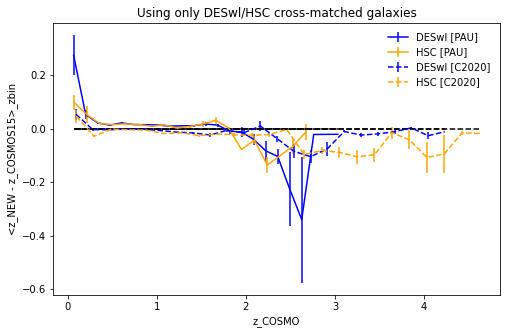

In [53]:
f = plt.figure(figsize=(8, 5))
plot_zdiff(zdiff['CP15_DESwl']['zC15'], zdiff['CP15_DESwl']['zdiff'], c='b', label='DESwl [PAU]')
plot_zdiff(zdiff['CP15_HSC']['zC15'], zdiff['CP15_HSC']['zdiff'], c='orange', label='HSC [PAU]')

plot_zdiff(zdiff['C15_20_DESwl']['zC15'], zdiff['C15_20_DESwl']['zdiff'], c='b', ls='--', label='DESwl [C2020]')
plot_zdiff(zdiff['C15_20_HSC']['zC15'], zdiff['C15_20_HSC']['zdiff'], c='orange', ls='--', label='HSC [C2020]')

plt.xlabel('z_COSMO')
plt.ylabel('<z_NEW - z_COSMOS15>_zbin')
# plt.ylim((-0.5, 0.5))
plt.title('Using only DESwl/HSC cross-matched galaxies')
plt.legend(frameon=False)
plt.show()
plt.close()